In [11]:
# Make predictions on data emailed by Claudio Feb 2022
# Author Peter Aug 5 2022
# The order of the parameters in each line is the usual one: alpha, cmf, cpa, pwr1par, pwr2par, pwr1perr, pwr2perr.
# For alpha and cmf, I added new values (alpha = 0, 10, 85; cmf = 2.5, 3.5, 9.5), which reflect more extreme conditions in the heliosphere: lower values of alpha and cmf correspond to a more quiet heliosphere, which result in less modulation of cosmic rays (less difference in the rigidity spectrum with respect to the local interstellar spectrum, the boundary condition at the external edge of the heliosphere), while higher values of alpha and cmf correspond to a more turbulent heliosphere, which result in more modulation.

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import matplotlib.pyplot as plt
import h5py
from collections import defaultdict

import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad
assert jax.default_backend() == 'gpu'

import elegy # pip install elegy
import optax
#import flax.linen
import tensorflow_io as tfio # pip install tensorflow-io
import tensorflow as tf # Recommended not to import this with jax because will also try to grab memory.

import pandas as pd
import gcr_utils 

infile = '../data/new_models.dat'
model_path = 'model_2_256_selu_l21e-6' #'model_2_256_selu_l21e-6_do' # 'model_2_256_selu_l21e-6' #'model_2_256_selu'

f = gcr_utils.define_nn_pred(model_path, 
                             normalize_input_flag=True, 
                             denormalize_output_flag=True,
                             rebin_output_flag=False)

def load_data():
    """ Load data from Claudio."""
    filename = '../data/new_models.dat'
    # Columns: alpha, cmf, cpa, pwr1par, pwr2par, pwr1perr, pwr2perr.
    # For alpha and cmf, I added new values (alpha = 0, 10, 85; cmf = 2.5, 3.5, 9.5)
    # This reflects more extreme conditions.
    #data = np.loadtxt(filename) # Rigidity1, Rigidity2, Flux, Error
    df = pd.read_csv(filename, delimiter=' ', names=['alpha', 'cmf', 'cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr', 'NAN'])
    df = df.drop(columns='NAN')  # Last column has no data.
    return df
    #data = np.loadtxt(filename) # Rigidity1, Rigidity2, Flux, Error
    #r1, r2 = dataset_ams[:,0], dataset_ams[:,1]
    #bins = np.concatenate([r1[:], r2[-1:]])
    #observed = dataset_ams[:,2]   # Observed Flux
    #uncertainty = dataset_ams[:,3]
    #assert len(bins) == len(observed)+1
    #return bins, observed, uncertainty, alpha, cmf

df = load_data()
df.head()

,alpha,cmf,cpa,pwr1par,pwr2par,pwr1perr,pwr2perr
0,0,2.5,50,0.5,0.5,0.5,0.5
1,0,2.5,50,0.5,0.5,0.5,1.1
2,0,2.5,50,0.5,0.5,0.5,1.7
3,0,2.5,50,0.5,0.5,0.5,2.3
4,0,2.5,50,0.5,0.5,1.1,0.5


In [20]:
# Run values through the NN model. 
x = df.iloc[0:3].to_numpy()
yhat = f(x)

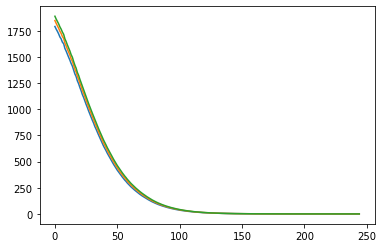

In [24]:
plt.plot(yhat.T)